# Tarea mod regresión con tutorial de LSTM

Este tutorial se enfoca a generar una estructura tal en los datos que permita un pronóstico hacia adelante. Es decir, buscamos generar una red neuronal a un conjunto de datos condicionados a eventos pasados, para luego generar un pronóstico futuro de los mismos. La serie por tanto genera una red entrenada en una sección de entrenamiento y prueba, como es común, para luego generar un pronóstico hacia adelante en una estructura de datos transformada. Es decir, esta estructura de datos contempla un conjunto de datos como entrada y una salida de manera anticipada que pueda ser empleada por el modelo supervisado. 

Algunas paqueterías en Python generan esta estructura mediante una función llamada TimeSeriesGenerator, lo cual puede ser un tanto retador si se hace de manera manual. La libreria de keras de deep learning provee esta función la cual, transforma series univariadas y multivariadas en este tipo de estructuras antes de poder aplicar el modelo y generar el pronóstico hacia adelante.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Visualización de datos financieros](#4)
1. [Preprocesamiento de datos](#5)
1. [Partición de datos en entrenamiento y prueba](#6)
1. [Definición de la estructura de datos transformada](#7)
1. [Diseño y entrenamiento de la red neuronal](#8)
1. [Incrustación del modelo en la estructura de datos para pronóstico de prueba](#9)
1. [Generación del pronóstico hacia adelante](#10)
1. [Visualización del pronóstico hacia adelante](#11)


<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [2]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf

# univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [1]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

In [3]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [57]:
##Si tienes problemas para descarlar pandas datareader, puedes probar la siguiente linea:
#!pip install git+https://github.com/pydata/pandas-datareader.git

<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fehca de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [4]:
#Establecemos las fechas de consulta:
start = '2015-01-01'
end = '2022-07-29'
#ticker = 'AAPL'
#data = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
amzn='AAPL'
#stks_tickers = ['AAPL','IBM', 'GOOGL']
#idx_tickers = ['SPY', '^DJI', '^VIX']
#ccy_tickers = ['JPY=X', 'GBPUSD=X']

In [5]:
#una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
apple = pdr.get_data_yahoo("AAPL", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [7]:
apple.head()

Date
2015-01-02    27.332500
2015-01-05    26.562500
2015-01-06    26.565001
2015-01-07    26.937500
2015-01-08    27.972500
Name: Close, dtype: float64

In [9]:
#pasamos a data frame los datos
dt= pandas.DataFrame(apple)
dt.head()

,Close
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500


In [10]:
#Identificamos la longitud de la serie
len(dt)

1906

In [11]:
#Damos un vistazo a los datos
dt.head()
dt.tail()

,Close
Date,
2022-07-22,154.089996
2022-07-25,152.949997
2022-07-26,151.600006
2022-07-27,156.789993
2022-07-28,157.350006


<a id="4"></a> <br>
### 3. Visualización de datos financieros

Podemos mirar la serie, debems importar la librería de matplotlib.

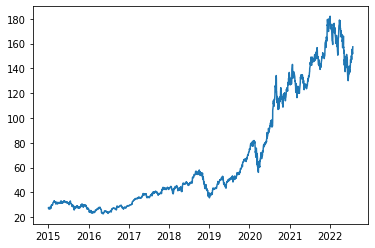

In [12]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

<a id="5"></a> <br>
### 4. Preprocesamiento de datos

En esta parte, debemos primero convertir nuestros datos tipo dataframe, a un objeto de pandas con fecha. Igualmente, la parte de valores de la serie, como el precio, lo pasamos a un tipo NumPy array que facilitará el procesamiento. 

dt['date'] = pd.to_datetime(dt.index)
dt.head()

In [17]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(dt.index)
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28'],
              dtype='datetime64[ns]', name='Date', length=1906, freq=None)

In [13]:
#Ahora, a numpy array:
dt2= apple.to_numpy()
dt2

array([ 27.33250046,  26.5625    ,  26.56500053, ..., 151.6000061 ,
       156.78999329, 157.3500061 ])

In [14]:
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 significa que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))
close_data

array([[ 27.33250046],
       [ 26.5625    ],
       [ 26.56500053],
       ...,
       [151.6000061 ],
       [156.78999329],
       [157.3500061 ]])

<a id="6"></a> <br>
### 5. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. Podemos tomar una referencia general de una proporción del 90/10 de la serie.

In [18]:
#Especificamos el porcentaje del corte.
split_percent = 0.90
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [19]:
date_train

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-18', '2021-10-19', '2021-10-20',
               '2021-10-21', '2021-10-22'],
              dtype='datetime64[ns]', name='Date', length=1715, freq=None)

In [20]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(close_train))
print(len(close_test))

1715
191


<a id="7"></a> <br>
### 6. Definición de la estructura de datos transformada

En esta seción, generamos la estructura de datos transformada para poder ser empleada en un model supervisado, incluyendo una red neuronal. Básicamente se trata de dar una estructura a partir de una ventana histórica de la serie, que siendo una serie financiera, esta ventana debiera ser la más reciente. Imaginarse que tenemos una serie como la siguiente:

[9,10,11,12,13,14,15,16,17]

Si estamos interesados en generar predicciones a un paso, las observaciones previas, llamadas, lags se emplean como entrada y la salida es la observación actual. Por ejemplo, la serie anterior de 9 pasos se puede expresar como un porblema de aprendizaje supervisado con tres time-steps como entrada y una de salida:

* [9,10,11] -> [12]
* [10,11,12]-> [13]
* [11,12,13]-> [14]
* [12,13,14]-> [15]
* [13,14,15]-> [16]
* [14,15,16]-> [17]


Para generar una estructura tal, existe un módulo en Keras llamado TimeseriesGenerator. Esta función embebe los datos dentro de esta función, generando un objeto que servirá de alimento a la red neuronal. Así, generamos primero los features en la serie.

In [21]:
#Especificamos la longitud o length, es el número de observaciones tipo lags a emplear en la porción de entrada de cada muestra, el ejemplo anterior era de 3.
#batch size representa en número de sub-series o muestras a generar en cada lote. En este caso, pueden ser uno o más. Por ejemplo, en la imagen anterior, el batch size es de 3.
n_back = 10   #la longitud 
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)     
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

In [24]:
# Podemos ver el número de muestras que se prepararán en los datos por el generador para esta serie
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))


Samples: 69
Samples: 181


In [60]:
#Podríamos imprimir  los componentes de entrada
#for i in range(len(train_generator)):
#	x, y = train_generator[i]
#	print('%s => %s' % (x, y))

<a id="8"></a> <br>
### 7. Diseño y entrenamiento de la red neuronal

En esta sección generamos primero el diseño de la red y la entrenamos acorde el número de epochs definidos y demás parámetros.

In [25]:
##Neural Net
#Importamos primero los módulos requeridos:
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(100,  ## de nodos
        activation='relu',
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

2022-10-28 21:53:55.822359: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-28 21:53:56.290516: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<a id="9"></a> <br>
### 8. Incrustación del modelo en la estructura de datos para pronóstico de prueba

En esta sección, vamos a embeber el modelo de la red neuronal a la estructura de datos previamente generada, en la sección de datos de prueba.

In [26]:
#Importamos primero el módulo para generar el gráfico animado.
import pandas as pd
import plotly.graph_objects as go

In [27]:
#Predicción en el set de prueba:
prediction = model.predict_generator(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))


In [53]:
#Podemos primeramente graficar las secciones: la serie de entrenamiento, la predicción en la sección de prueba y la sección de prueba.
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Entrenamiento'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Prueba'
)
layout = go.Layout(
    title = "Apple Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

<a id="10"></a> <br>
### 9. Generación del pronóstico hacia adelante

En esta sección, ya teniendo la serie entrenada con la red neuronal, aplicamos el modelo a la ventana histórica indicada equivalente para generar el pronóstico.

In [29]:
##Identificamos la posición del último valor de la serie.
dataindex[1905]

Timestamp('2022-07-28 00:00:00')

In [30]:
##Forecasting: Generamos el pronóstico hacia adelante acorde el modelo entrenado, a partir de la última fecha. en este caso generaremos 10 observaciones futuras y finalmente anexaremos las fechas correspondientes.
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = dataindex[1905]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 10
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [31]:
#Podemos observar las fechas hacia adelante.
forecast_dates

[Timestamp('2022-07-28 00:00:00', freq='D'),
 Timestamp('2022-07-29 00:00:00', freq='D'),
 Timestamp('2022-07-30 00:00:00', freq='D'),
 Timestamp('2022-07-31 00:00:00', freq='D'),
 Timestamp('2022-08-01 00:00:00', freq='D'),
 Timestamp('2022-08-02 00:00:00', freq='D'),
 Timestamp('2022-08-03 00:00:00', freq='D'),
 Timestamp('2022-08-04 00:00:00', freq='D'),
 Timestamp('2022-08-05 00:00:00', freq='D'),
 Timestamp('2022-08-06 00:00:00', freq='D'),
 Timestamp('2022-08-07 00:00:00', freq='D')]

In [32]:
#Los valores del pronóstico
forecast

array([157.3500061 , 156.29844666, 156.87011719, 157.93547058,
       158.79014587, 159.23950195, 159.61659241, 160.25393677,
       161.00643921, 161.88835144, 162.4304657 ])

<a id="7a"></a> <br>
# Sección 2. Regresión con Random Forest

<a id="5"></a> <br>
### 2.1. Preprocesamiento de datos

En esta parte, debemos primero convertir nuestros datos tipo dataframe, a un objeto de pandas con fecha. Igualmente, la parte de valores de la serie, como el precio, lo pasamos a un tipo NumPy array que facilitará el procesamiento.

In [33]:
data = dt.rename(columns={'Close': 'y'})
data

,y
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500
...,...
2022-07-22,154.089996
2022-07-25,152.949997
2022-07-26,151.600006


In [34]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(data.index)
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28'],
              dtype='datetime64[ns]', name='Date', length=1906, freq=None)

<a id="6"></a> <br>
### 2.2. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. Podemos tomar una referencia general de una proporción del 90/10 de la serie.

In [35]:
#Especificamos los ultimos datos que servirán para la parte de testing o capacidad predictiva del modelo.

steps=int(round(len(dt)*.1,0))
steps

191

In [36]:

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
data_train = data[:-steps]
data_test  = data[-steps:]

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

In [37]:
#Vemos los datos para las fechas que nos sirven para las gráficas
date_train
#date_test  #Igualmente para visualizarlos

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-18', '2021-10-19', '2021-10-20',
               '2021-10-21', '2021-10-22'],
              dtype='datetime64[ns]', name='Date', length=1715, freq=None)

In [46]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

1715
191


<a id="7"></a> <br>
### 2.3. Visualización conjunto de entrenamiento y prueba

In [38]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Apple Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

<a id="8"></a> <br>
### 2.4. Creación del Forecaster para el modelo de Random Forest

En esta sección aplicamos la función de Forecast Aurtoregress para la creación de ventanas con ciertos retrazos al cual se aplica el modelo de Random Forest. En este caso, consideramos 10 retrazos que capturan la estructura de datos de la serie y generan un pronóstico a 10 días. Esto significa que el modelo emplea los 10 días previos como predictores. 

In [39]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 996.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 19.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 28.2 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3

In [40]:
# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [41]:
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


In [42]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 10
                )

forecaster.fit(y = data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 1714] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-28 21:58:05 
Last fit date: 2022-10-28 21:58:06 
Skforecast version: 0.5.1 
Python version: 3.7.12 

<a id="9"></a> <br>
### 2.5. Predicciones en conjunto de prueba

In [43]:
# Pronóstico, en este caso elegimos una ventana de 191 días.
# ==============================================================================
steps = 191
predictions = forecaster.predict(steps=steps)
predictions.head(5)

10    147.986000
11    148.481600
12    149.088501
13    149.713200
14    149.103199
Name: pred, dtype: float64

<a id="11"></a> <br>
### 11. Calculo del error

Empleamos los resultados para calcular el error RMSE de la sección de prueba. 

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
import math

In [49]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse = mean_squared_error(
                y_true = close_test,
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = math.sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 277.2421814737108
Test error (rmse): 16.65059102475677


<a id="11"></a> <br>
### 10. Visualización del pronóstico hacia adelante

Finalmente, podemos generar una visuzlización de la serie, tanto de las secciones de entrenamiento, prueba y el pronóstico hacia adelante.

In [58]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Entrenamiento'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Prueba'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = predictions,
    mode='lines',
    name = 'Pronostico RF'
)

layout = go.Layout(
    title = "Apple Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()

En este tutorial aprendiste la importancia de transformar los datos de una serie de tiempo en una estructura de datos que permiten generar secuencias de entrenamiento y pronóstico de la serie con base en datos históricos. Este proceso se debe hacer especialmente cuando deseamos generar un pronóstico hacia adelante en series de tiempo. Dicho proceso es muy similar al que se emplea cuando aplicamos un problema supervisado tal como una regresión lineal, donde se generan los retrasos o lags de la serie y cuyos features ingresan al modelo de regresión. En este caso, se crea una estructura en la cual se puede emplear para entrenar una red neuronal cuyo proceso pouede ser tedioso, para ello la función de timeseriesGenerator de Keras facilita el proceso. 

Ref: https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816